### Model for MA assuming: (1) constant waste from each location, (2) at time T when all panels expired and ready to be recycled, (3) Haversine distance (instead of Google Maps data)

### Key Assumptions
- **Facility Construction**: $200,000 - $700,000 (1,000-5,000 tons/year capacity)
- **Processing Cost**: $500/ton (excluding transportation)
- **Recovered Material Value**: $800/ton
- **Landfill Disposal Cost**: $200/ton
- **Transportation Cost**: $3.14/mile

### Formulation

### Sets
- $I$ = Candidate facility locations (95 locations)
- $J$ = Solar panel locations (622 locations)

### Parameters
- $d_{ij}$ = Distance from facility $i$ to solar plant $j$ (miles)
- $w_j$ = Waste generated at solar plant $j$ (tons)
- $c^{fixed}_i$ = Fixed cost of opening facility $i$
- $c^{p}$ = Processing cost per ton ($500)
- $c^{t}$ = Transportation cost per ton-mile ($3.14)
- $r^{value}$ = Recovered material value per ton ($800)
- $c^{landfill}$ = Landfill disposal cost per ton ($200)
- $K^{min}, K^{max}$ = Minimum and maximum facility capacity (tons/year)

### Decision Variables
- $y_i \in \{0,1\}$ = 1 if facility $i$ is opened, 0 otherwise
- $x_{ij} \geq 0$ = Amount of waste sent from plant $j$ to facility $i$ (tons)
- $l_j \geq 0$ = Amount of waste from plant $j$ sent to landfill (tons)
- $k_i \geq 0$ = Capacity of facility $i$ (tons/year)

### Objective Function
$$\min \sum_{i \in I} c^{fixed}_i \cdot y_i + \sum_{i \in I} \sum_{j \in J} (c^{p} + c^{t} \cdot d_{ij} - r^{value}) \cdot x_{ij} + \sum_{j \in J} c^{landfill} \cdot l_j$$

### Constraints
1. **Waste Balance**: All waste must be either recycled or sent to landfill
   $$\sum_{i \in I} x_{ij} + l_j = w_j \quad \forall j \in J$$

2. **Capacity Limits**: Facility capacity bounds
   $$K^{min} \cdot y_i \leq k_i \leq K^{max} \cdot y_i \quad \forall i \in I$$

3. **Capacity Usage**: Processing cannot exceed capacity
   $$\sum_{j \in J} x_{ij} \leq k_i \quad \forall i \in I$$

4. **Facility Opening**: Can only send waste to open facilities
   $$x_{ij} \leq M \cdot y_i \quad \forall i \in I, j \in J$$

In [1]:
using Pkg

# Pkg.add("Plots")
# Pkg.add("Statistics")
# Pkg.add("HTTP")
# Pkg.add("JSON")
using JuMP
using CSV, DataFrames
using Statistics
using Plots
using HTTP
using JSON

### 1. Data Loading and Preprocessing

In [3]:
possible_facilities = Matrix(CSV.read("possible_facilities.csv", DataFrame; header=false))
plant_locations = Matrix(CSV.read("cleaned_plant_locations.csv", DataFrame; header=false))

# Check number of facilities and plants
n_facilities = size(possible_facilities, 1)  # 95 locations
n_plants = size(plant_locations, 1)          # 622 

println("$n_facilities")
println("$n_plants")

95
622


Distance Matrix using Haversine (instead of Google Maps data)

In [5]:
# Haversine distance function
function haversine_distance(lat1, lon1, lat2, lon2)
    R = 3958.8  # Earth radius in miles
    # Convert to radians
    lat1_rad = deg2rad(lat1)
    lat2_rad = deg2rad(lat2)
    dlat = deg2rad(lat2 - lat1)
    dlon = deg2rad(lon2 - lon1)
    # Haversine formula
    a = sin(dlat/2)^2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)^2
    c = 2 * asin(sqrt(a))
    return R * c
end

# Get distance matrix in miles
distance_matrix = zeros(n_facilities, n_plants)

for i in 1:n_facilities
    for j in 1:n_plants
        distance_matrix[i, j] = haversine_distance(
            possible_facilities[i, 1], possible_facilities[i, 2],
            plant_locations[j, 1], plant_locations[j, 2]
        )
    end
end

println("$(size(distance_matrix))")


(95, 622)


### 2. Define Costs

In [ ]:
# Facility construction costs (scales with capacity)
fixed_cost_min = 200000.0    
fixed_cost_max = 700000.0    
capacity_min = 1000.0       
capacity_max = 5000.0        

# Operating costs per ton
processing_cost = 500.0      
recovered_value = 800.0      
landfill_cost = 200.0         

# Transportation cost
transport_cost_per_mile = 3.14  # $/mile

# Net processing cost
net_processing_cost = processing_cost - recovered_value 

# Panel (assuming constant for all locations)
waste_per_installation = 1.9 #tons
waste = fill(waste_per_installation, n_plants)

fixed_cost_base = 200000.0
fixed_cost_per_ton_capacity = (fixed_cost_max - fixed_cost_min) / (capacity_max - capacity_min)


125.0

## 3. Model

In [ ]:
using Gurobi
model = Model(Gurobi.Optimizer)
set_optimizer_attribute(model, "TimeLimit", 300)
set_optimizer_attribute(model, "MIPGap", 0.01)

#Decision Variables
# y[i]
@variable(model, y[1:n_facilities], Bin)

# x[i,j] = amount of waste sent from plant j to facility i 
@variable(model, x[1:n_facilities, 1:n_plants] >= 0)
    
# l[j] = amount of waste from plant j sent to landfill
@variable(model, l[1:n_plants] >= 0)
    
# k[i] = capacity of facility i (tons/year)
@variable(model, k[1:n_facilities] >= 0)


# Constraints 
# Waste Balance
@constraint(model, waste_balance[j=1:n_plants],
    sum(x[i, j] for i in 1:n_facilities) + l[j] == waste[j])

# Capacity Lower Bound
@constraint(model, cap_min_constraint[i=1:n_facilities],
    k[i] >= capacity_min * y[i])

#Capacity Upper Bound
@constraint(model, cap_max_constraint[i=1:n_facilities],
    k[i] <= capacity_max * y[i])

#Capacity Usage
@constraint(model, capacity_usage[i=1:n_facilities],
    sum(x[i, j] for j in 1:n_plants) <= k[i])

#Can only send waste to open facilities
M = maximum(waste)
@constraint(model, facility_open[i=1:n_facilities, j=1:n_plants],
    x[i, j] <= M * y[i])


Set parameter Username
Set parameter LicenseID to value 2703562
Academic license - for non-commercial use only - expires 2026-09-05
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.01


95×622 Matrix{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 facility_open[1,1] : -1.9 y[1] + x[1,1] ≤ 0     …  facility_open[1,622] : -1.9 y[1] + x[1,622] ≤ 0
 facility_open[2,1] : -1.9 y[2] + x[2,1] ≤ 0        facility_open[2,622] : -1.9 y[2] + x[2,622] ≤ 0
 facility_open[3,1] : -1.9 y[3] + x[3,1] ≤ 0        facility_open[3,622] : -1.9 y[3] + x[3,622] ≤ 0
 facility_open[4,1] : -1.9 y[4] + x[4,1] ≤ 0        facility_open[4,622] : -1.9 y[4] + x[4,622] ≤ 0
 facility_open[5,1] : -1.9 y[5] + x[5,1] ≤ 0        facility_open[5,622] : -1.9 y[5] + x[5,622] ≤ 0
 facility_open[6,1] : -1.9 y[6] + x[6,1] ≤ 0     …  facility_open[6,622] : -1.9 y[6] + x[6,622] ≤ 0
 facility_open[7,1] : -1.9 y[7] + x[7,1] ≤ 0        facility_open[7,622] : -1.9 y[7] + x[7,622] ≤ 0
 facility_open[8,1] : -1.9 y[8] + x[8,1] ≤ 0        facility_open[8,622] : -1.9 y[8] + x[8,622] ≤ 0
 facility_open[9,1] : -1.9 y[9] 

In [ ]:
# Objective Function
transport_cost = transport_cost_per_mile .* distance_matrix

@objective(model, Min,

    sum(fixed_cost_base * y[i] + fixed_cost_per_ton_capacity * k[i] for i in 1:n_facilities) +
    sum(net_processing_cost * x[i, j] for i in 1:n_facilities, j in 1:n_plants) +
    sum(transport_cost[i, j] * x[i, j] for i in 1:n_facilities, j in 1:n_plants) +
    sum(landfill_cost * l[j] for j in 1:n_plants)
)

200000 y[1] + 125 k[1] + 200000 y[2] + 125 k[2] + 200000 y[3] + 125 k[3] + 200000 y[4] + 125 k[4] + 200000 y[5] + 125 k[5] + 200000 y[6] + 125 k[6] + 200000 y[7] + 125 k[7] + 200000 y[8] + 125 k[8] + 200000 y[9] + 125 k[9] + 200000 y[10] + 125 k[10] + 200000 y[11] + 125 k[11] + 200000 y[12] + 125 k[12] + 200000 y[13] + 125 k[13] + 200000 y[14] + 125 k[14] + 200000 y[15] + 125 k[15] + [[...59842 terms omitted...]] + 200 l[593] + 200 l[594] + 200 l[595] + 200 l[596] + 200 l[597] + 200 l[598] + 200 l[599] + 200 l[600] + 200 l[601] + 200 l[602] + 200 l[603] + 200 l[604] + 200 l[605] + 200 l[606] + 200 l[607] + 200 l[608] + 200 l[609] + 200 l[610] + 200 l[611] + 200 l[612] + 200 l[613] + 200 l[614] + 200 l[615] + 200 l[616] + 200 l[617] + 200 l[618] + 200 l[619] + 200 l[620] + 200 l[621] + 200 l[622]

### 4. Solve the Model

In [14]:
optimize!(model)

Set parameter MIPGap to value 0.01
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
TimeLimit  300
MIPGap  0.01

Optimize a model with 59997 rows, 59902 columns and 237457 nonzeros
Model fingerprint: 0xf9253e74
Variable types: 59807 continuous, 95 integer (95 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [5e-03, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 236360.00000
Presolve removed 1248 rows and 1153 columns
Presolve time: 0.38s
Presolved: 58749 rows, 58749 columns, 232783 nonzeros
Variable types: 58654 continuous, 95 integer (95 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.22s (can be avoided by choosing

In [16]:

if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.TIME_LIMIT

    # Optimal objective value
    opt_cost = objective_value(model)
    println("\nTotal System Cost: \$$(round(opt_cost, digits=2))")
    
    # Get solution values
    y_val = value.(y)
    x_val = value.(x)
    l_val = value.(l)
    k_val = value.(k)
    open_facilities = findall(y_val .> 0.5)
    
    # Display facility details
    println("\nOpened Facilities")
    println("ID\tLatitude\tLongitude\tCapacity (tons)\tUtilization")
    for i in open_facilities
        capacity = k_val[i]
        utilization = sum(x_val[i, :]) / capacity * 100
        lat = round(possible_facilities[i, 1], digits=4)
        lon = round(possible_facilities[i, 2], digits=4)
        println("$i\t$lat\t\t$lon\t\t$(round(capacity, digits=1))\t\t$(round(utilization, digits=1))%")
    end
    
    
    
else
    println("Model did not solve to optimality.")
    println("Status: $(termination_status(model))")
end


Total System Cost: $134774.18

Opened Facilities
ID	Latitude	Longitude	Capacity (tons)	Utilization
46	42.2556		-71.8077		1181.8		100.0%


### 5. Visualize 

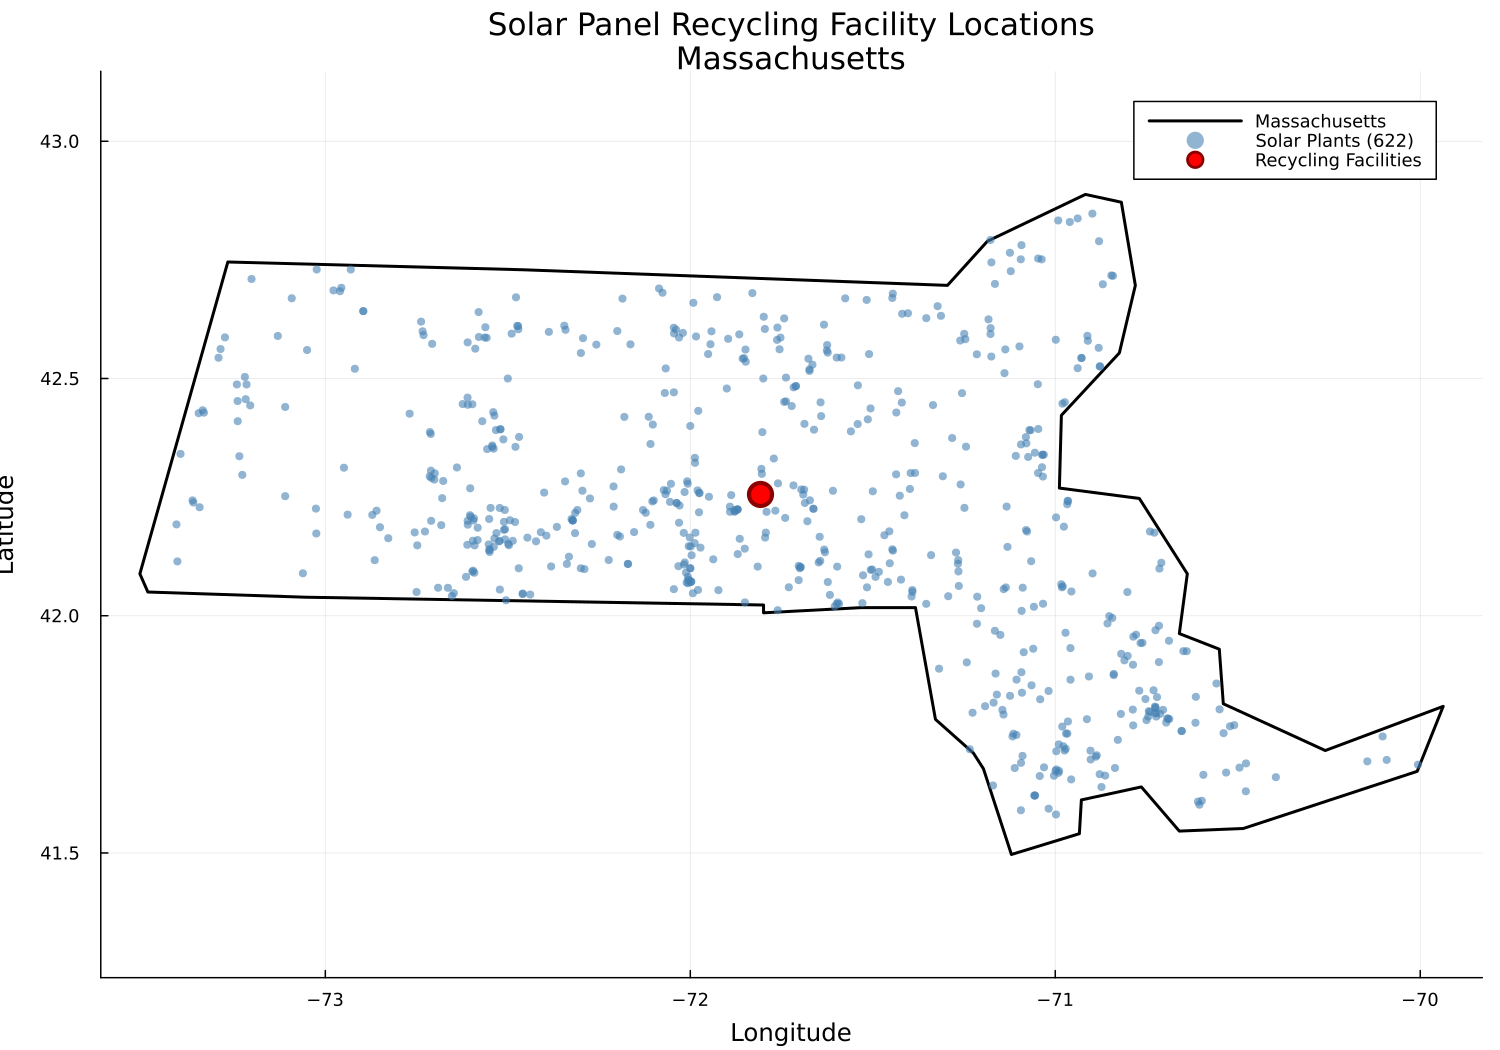

In [ ]:

# Function to download MA map
function get_ma_boundary()
    url = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json"
    response = HTTP.get(url)
    data = JSON.parse(String(response.body))
    
    # Find Massachusetts
    for feature in data["features"]
        if feature["properties"]["name"] == "Massachusetts"
            return feature["geometry"]["coordinates"]
        end
    end
    return nothing
end


ma_coords = get_ma_boundary()
ma_lons = Float64[]
ma_lats = Float64[]

if ma_coords !== nothing
    for polygon in ma_coords
        # Handle MultiPolygon structure
        if typeof(polygon[1][1]) <: AbstractVector
            for ring in polygon
                for coord in ring
                    push!(ma_lons, coord[1])
                    push!(ma_lats, coord[2])
                end
                push!(ma_lons, NaN)  # Break between polygons
                push!(ma_lats, NaN)
            end
        else
            for coord in polygon
                push!(ma_lons, coord[1])
                push!(ma_lats, coord[2])
            end
            push!(ma_lons, NaN)
            push!(ma_lats, NaN)
        end
    end
end


if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.TIME_LIMIT
    
    # Create plot with Massachusetts boundary
    p = plot(ma_lons, ma_lats,
        linecolor=:black,
        linewidth=2,
        fillalpha=0.1,
        fillcolor=:lightgray,
        label="Massachusetts",
        xlabel="Longitude",
        ylabel="Latitude",
        title="Solar Panel Recycling Facility Locations\nMassachusetts",
        legend=:topright,
        size=(1000, 700),
        dpi=150,
        aspect_ratio=1.3
    )
    
    # Plot solar plant locations
    scatter!(plant_locations[:, 2], plant_locations[:, 1],
        label="Solar Plants ($(n_plants))",
        markersize=3,
        markercolor=:steelblue,
        alpha=0.6,
        markerstrokewidth=0
    )
    
    # Plot opened facilities with size proportional to capacity
    for (idx, i) in enumerate(open_facilities)
        capacity = k_val[i]
        size_factor = 8 + 12 * (capacity - capacity_min) / (capacity_max - capacity_min)
        scatter!([possible_facilities[i, 2]], [possible_facilities[i, 1]],
            label= i == open_facilities[1] ? "Recycling Facilities" : "",
            markersize=size_factor,
            markercolor=:red,
            markerstrokecolor=:darkred,
            markerstrokewidth=2
        )
    end
    
    display(p)
    # savefig(p, "facility_locations.png")
end